#**Blending - AdaBoost (Regression)**

**Import Libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing  # Use California Housing Dataset
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import clone
from sklearn.decomposition import PCA

**Code**

In [2]:
# Load the California housing dataset (for regression)
data = fetch_california_housing()
X, y = data.data, data.target

In [3]:
# Split the dataset into training and testing sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Further split the training set into a train and validation set (for blending)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [5]:
# Define base regressors
base_regressors = [
    ('adaboost', AdaBoostRegressor(n_estimators=50, random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=50, random_state=42)),
    # ('gb', GradientBoostingRegressor(n_estimators=50, random_state=42)),
    # ('svr', SVR(kernel='linear'))  # SVR for regression tasks
]

In [6]:
# Step 1: Train base regressors on the training set
val_predictions = np.zeros((X_val.shape[0], len(base_regressors)))  # Placeholder for validation predictions
test_predictions = np.zeros((X_test.shape[0], len(base_regressors)))  # Placeholder for test set predictions

individual_mse = []

for i, (name, reg) in enumerate(base_regressors):
    # Clone the regressor to avoid overwriting during blending
    reg_instance = clone(reg)

    # Train on the full training set
    reg_instance.fit(X_train, y_train)

    # Store predictions on the validation set
    val_predictions[:, i] = reg_instance.predict(X_val)

    # Store predictions on the test set
    test_predictions[:, i] = reg_instance.predict(X_test)

    # Calculate individual mean squared error
    individual_pred = reg_instance.predict(X_test)
    mse = mean_squared_error(y_test, individual_pred)
    individual_mse.append((name, mse))

In [7]:
# Step 2: Blend predictions using a linear regression model
blender = LinearRegression()
blender.fit(val_predictions, y_val)

LinearRegression()

In [8]:
# Step 3: Make final predictions on the test set using the blender
final_predictions = blender.predict(test_predictions)

In [9]:
# Calculate and display the MSE and R² score of the blended model
blended_mse = mean_squared_error(y_test, final_predictions)
blended_r2 = r2_score(y_test, final_predictions)
print(f'Blended Model MSE: {blended_mse:.2f}')
print(f'Blended Model R² Score: {blended_r2:.2f}')

Blended Model MSE: 0.27
Blended Model R² Score: 0.79


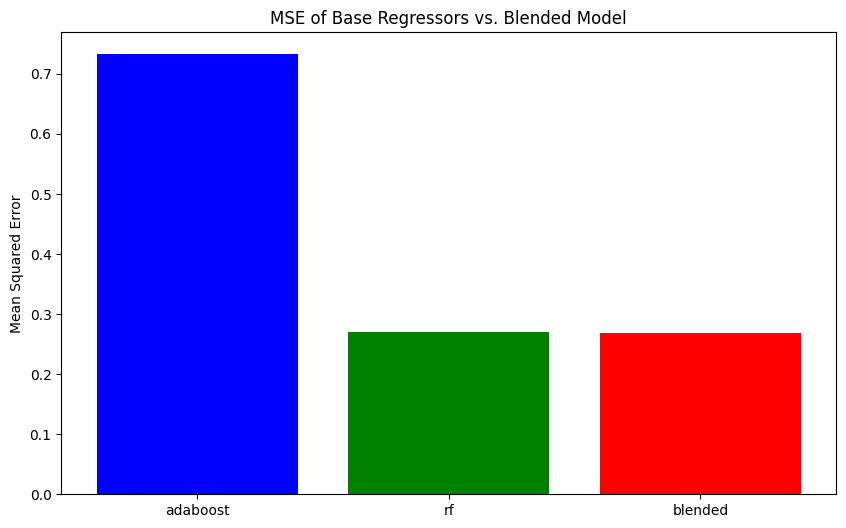

In [10]:
# Visualization of MSE for base regressors vs. blended model
names, mse_values = zip(*individual_mse)
plt.figure(figsize=(10, 6))
plt.bar(names + ('blended',), mse_values + (blended_mse,), color=['blue', 'green', 'red', 'purple', 'orange'])
plt.ylabel('Mean Squared Error')
plt.title('MSE of Base Regressors vs. Blended Model')
plt.show()

In [11]:
# Apply PCA to reduce the dimensions to 2 for visualization
pca = PCA(n_components=2)
test_predictions_2d = pca.fit_transform(test_predictions)

In [12]:
# Train a linear regression model on the PCA-transformed data for visualization
blender_pca = LinearRegression()
blender_pca.fit(test_predictions_2d, y_test)

LinearRegression()

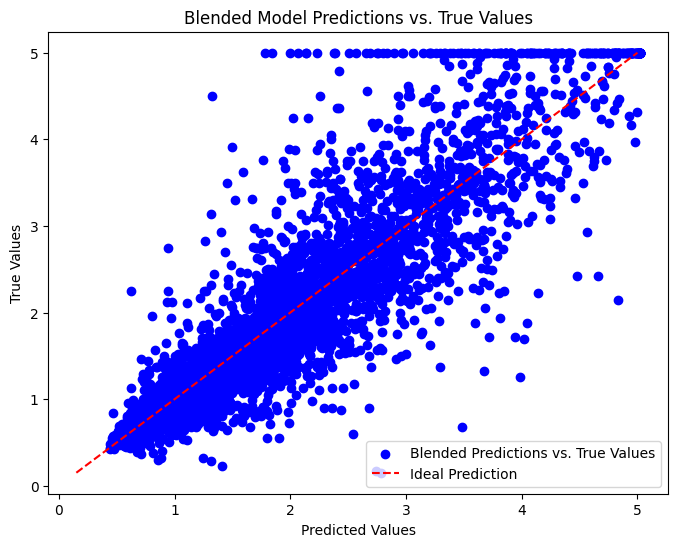

In [13]:
# Plot a scatter plot for blended predictions
plt.figure(figsize=(8, 6))
plt.scatter(final_predictions, y_test, color='blue', label='Blended Predictions vs. True Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal Prediction')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.legend()
plt.title('Blended Model Predictions vs. True Values')
plt.show()